In [58]:
import numpy as np
from numpy import pi
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_cloud", token="4PkG3WlXufZct6TqMYVREZ820GSfbt8G1RezJuKTT22O",overwrite=True)
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [59]:
qc=QuantumCircuit(3)

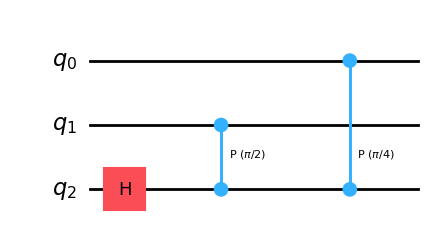

In [60]:
qc.h(2)
qc.cp(pi/2,1,2)
qc.cp(pi/4,0,2)
qc.draw('mpl')

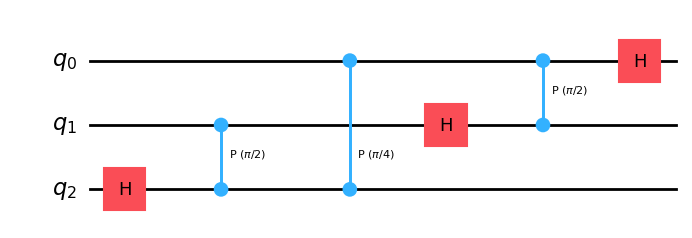

In [61]:
qc.h(1)
qc.cp(pi/2,0,1)
qc.h(0)
qc.draw('mpl')

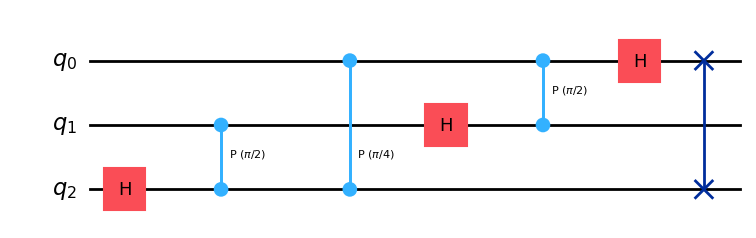

In [62]:
qc.swap(0,2)
qc.draw('mpl')

In [63]:
def qft_rotation(circuit, n):
    if n==0:
        return 'Circuit empty'
    n-=1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)

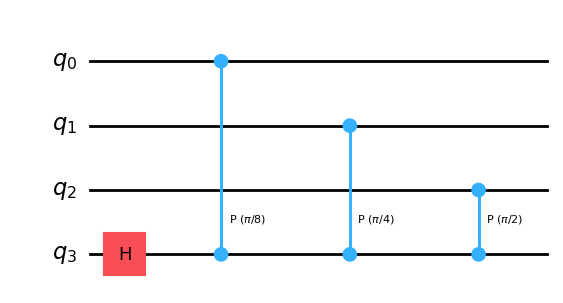

In [64]:
qc=QuantumCircuit(4)
qft_rotation(qc,4)
qc.draw('mpl')

In [65]:
from qiskit_textbook.widgets import scalable_circuit
scalable_circuit(qft_rotation)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xc1\x00\x00\x01o\x08\x06\x00\x00\x00\xabO\x16w\x…

In [66]:
!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src


  Cloning https://github.com/qiskit-community/qiskit-textbook.git to c:\users\anushka\appdata\local\temp\pip-req-build-w10n5krx


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [67]:
def qft_rotation(circuit, n):
    if n==0:
        return 'Circuit empty'
    n-=1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotation(circuit, n)

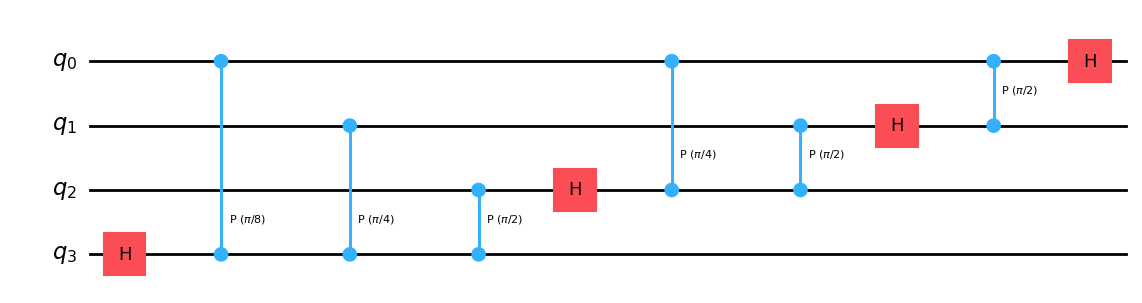

In [68]:
qc = QuantumCircuit(4)
qft_rotation(qc,4)
qc.draw('mpl')

In [69]:
scalable_circuit(qft_rotation)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\xb2\x00\x00\x01o\x08\x06\x00\x00\x00\x9f\n=o\x00…

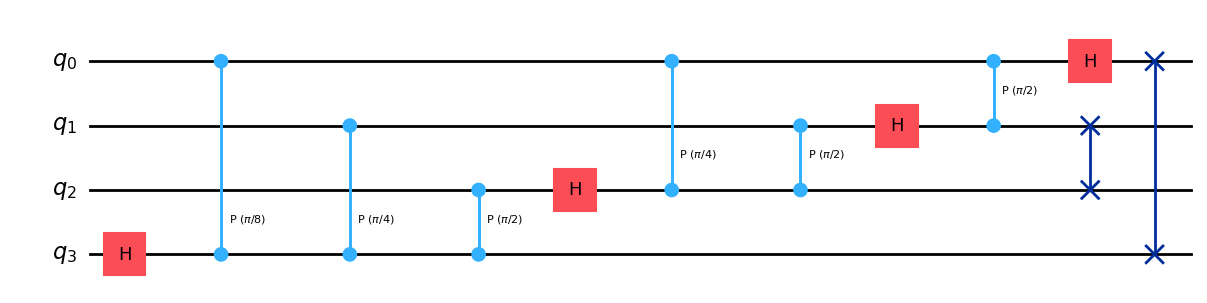

In [70]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    qft_rotation(circuit,n)
    swap_registers(circuit, n)
    return circuit

qc=QuantumCircuit(4)
qft(qc,4)
qc.draw('mpl')

In [71]:
scalable_circuit(qft)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\x05\x00\x00\x01o\x08\x06\x00\x00\x00j\xc2\xcb.\x…

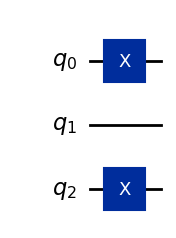

In [72]:
qc=QuantumCircuit(3)
qc.x(0)
qc.x(2)
qc.draw('mpl')

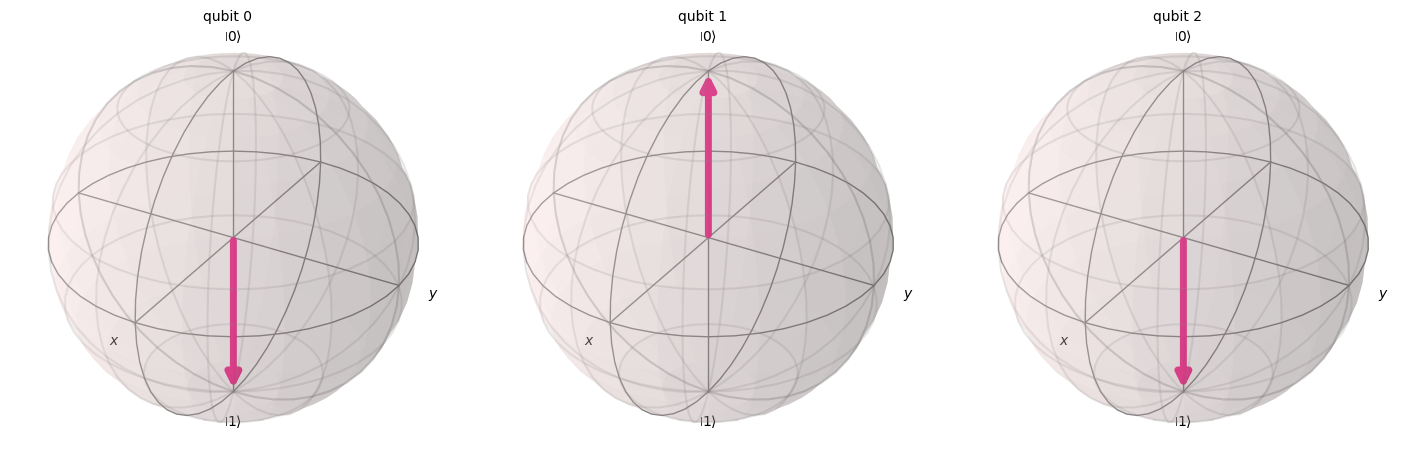

In [73]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

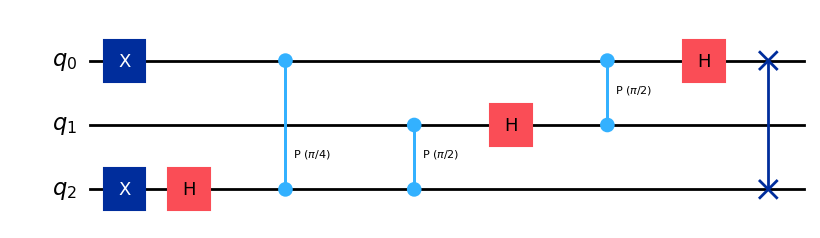

In [74]:
qft(qc,3)
qc.draw('mpl')

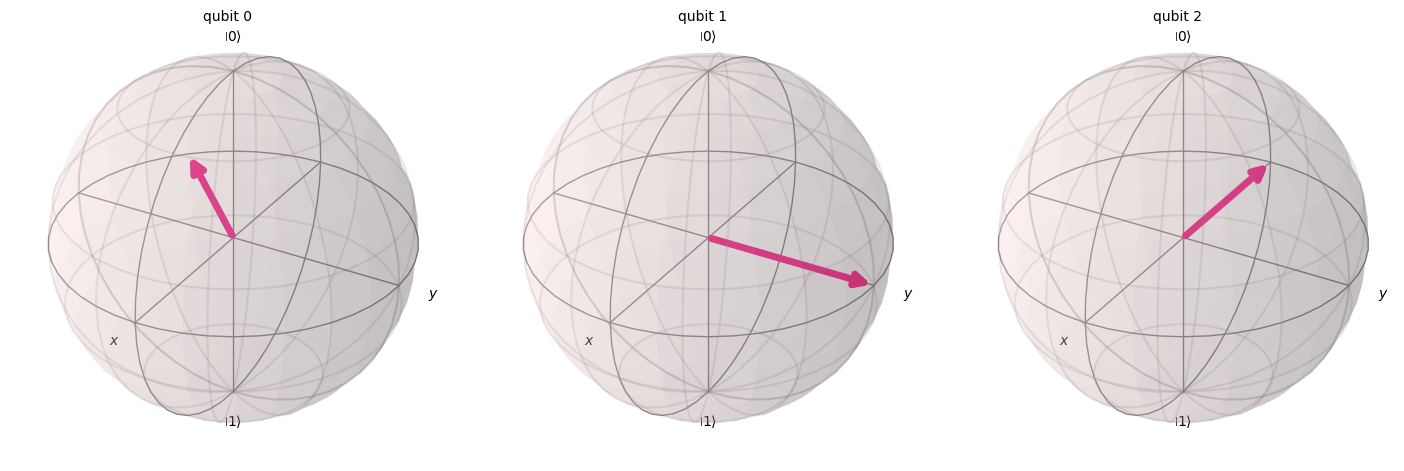

In [75]:
qc.save_statevector()
statevector=sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

In [76]:
def inverse_qft(circuit, n):
    qft_circ=qft(QuantumCircuit(n), n)
    iqft=qft_circ.inverse()
    circuit.append(iqft, circuit.qubits[:n])
    return circuit.decompose()

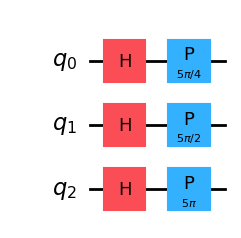

In [77]:
nqubits=3
number=5
qc=QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(pi*number/4,0)
qc.p(pi*number/2,1)
qc.p(pi*number,2)
qc.draw('mpl')

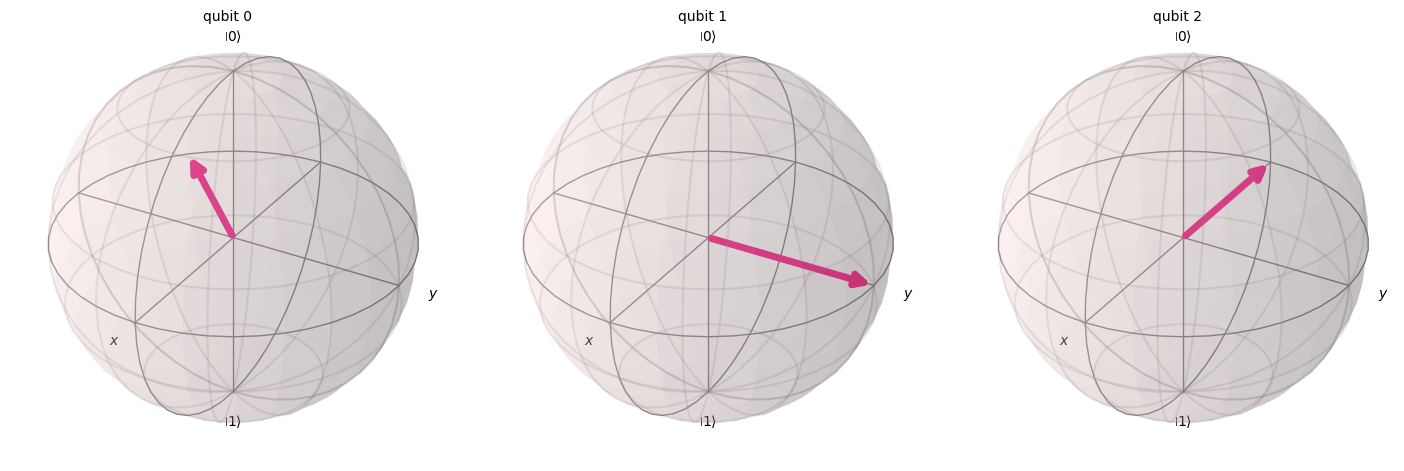

In [78]:
qc_init=qc.copy()
qc_init.save_statevector()
statvector=sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

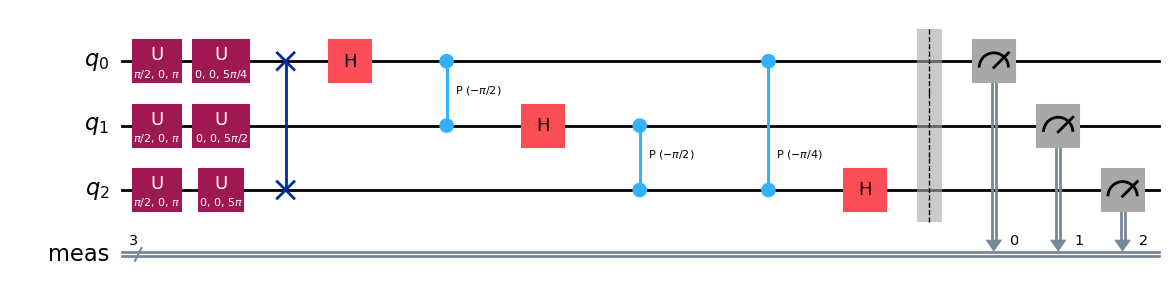

In [79]:
qc=inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw('mpl')

In [82]:
service=QiskitRuntimeService()
backend=service.least_busy(operational=True, simulator=False, min_num_qubits=20)
print(f"backend: {backend.name}")

qiskit_runtime_service.__init__:WARNING:2025-12-17 16:16:56,462: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-17 16:16:57,265: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-17 16:16:59,896: Using instance: open-instance, plan: open


backend: ibm_torino


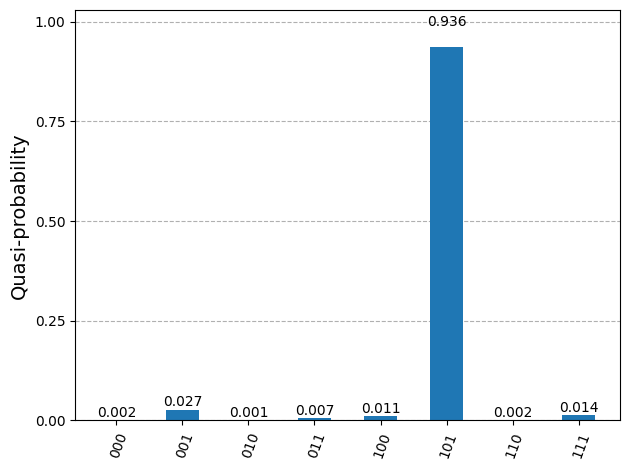

In [87]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
pm=generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit=pm.run(qc)
sampler=Sampler(mode=backend)
result=sampler.run([isa_circuit]).result()
counts=result[0].data.meas.get_counts()
total=sum(counts.values())
probabilities={bit: count/total for bit, count in counts.items()}
plot_histogram(probabilities)